In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap
import sys

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from utils import *

## Loading data

In [2]:
path = ''
df_original = pd.read_csv(path + 'data/adult.data', header=None)
df_original.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
df_original.drop(['fnlwgt'], axis=1, inplace=True)
print(df_original.shape)
df_original.head()

(32561, 14)


,Age,WorkClass,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocessing

In [3]:
columns_cat = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 
               'Relationship', 'NativeCountry', 'Income', 'Race', 'Gender']

for col_cat in columns_cat:
    df_original[col_cat] = df_original[col_cat].str.strip()

In [4]:
df_proces = df_original.copy()

df_proces['Race'] = df_proces['Race'].apply(lambda row: 1 if row == 'White' else 0)
df_proces['Gender'] = df_proces['Gender'].apply(lambda row: 1 if row == 'Male' else 0)
df_proces['Income'] = df_proces['Income'].apply(lambda row: 0 if row == '<=50K' else 1)

columns_cat = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 
               'Relationship', 'NativeCountry']

df_proces = pd.get_dummies(df_proces, columns=columns_cat)
df_proces = df_proces.astype(float)
df_proces.head()

,Age,EducationNum,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,Income,WorkClass_?,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Never-worked,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,WorkClass_State-gov,WorkClass_Without-pay,Education_10th,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,Education_Assoc-acdm,Education_Assoc-voc,Education_Bachelors,Education_Doctorate,Education_HS-grad,Education_Masters,Education_Preschool,Education_Prof-school,Education_Some-college,MaritalStatus_Divorced,MaritalStatus_Married-AF-spouse,MaritalStatus_Married-civ-spouse,MaritalStatus_Married-spouse-absent,MaritalStatus_Never-married,MaritalStatus_Separated,MaritalStatus_Widowed,Occupation_?,Occupation_Adm-clerical,Occupation_Armed-Forces,Occupation_Craft-repair,Occupation_Exec-managerial,Occupation_Farming-fishing,Occupation_Handlers-cleaners,Occupation_Machine-op-inspct,Occupation_Other-service,Occupation_Priv-house-serv,Occupation_Prof-specialty,Occupation_Protective-serv,Occupation_Sales,Occupation_Tech-support,Occupation_Transport-moving,Relationship_Husband,Relationship_Not-in-family,Relationship_Other-relative,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,NativeCountry_?,NativeCountry_Cambodia,NativeCountry_Canada,NativeCountry_China,NativeCountry_Columbia,NativeCountry_Cuba,NativeCountry_Dominican-Republic,NativeCountry_Ecuador,NativeCountry_El-Salvador,NativeCountry_England,NativeCountry_France,NativeCountry_Germany,NativeCountry_Greece,NativeCountry_Guatemala,NativeCountry_Haiti,NativeCountry_Holand-Netherlands,NativeCountry_Honduras,NativeCountry_Hong,NativeCountry_Hungary,NativeCountry_India,NativeCountry_Iran,NativeCountry_Ireland,NativeCountry_Italy,NativeCountry_Jamaica,NativeCountry_Japan,NativeCountry_Laos,NativeCountry_Mexico,NativeCountry_Nicaragua,NativeCountry_Outlying-US(Guam-USVI-etc),NativeCountry_Peru,NativeCountry_Philippines,NativeCountry_Poland,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
0,39.0,13.0,1.0,1.0,2174.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50.0,13.0,1.0,1.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53.0,7.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28.0,13.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
metadata = {'label_maps': [{0.0: '<=50K', 1.0: '>50K'}], 
            'protected_attribute_maps': [{0.0: 'Female', 1.0: 'Male'}]}
unprivileged_groups=[{'Gender': [0.0]}]
privileged_groups=[{'Gender': [1.0]}]
protected_attribute_names = ['Gender']
label_names = ['Income']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 3
name_protect = 'Gender'

Disparate impact dados originais:  0.6419774503186488


In [6]:
lst_res = []

## Model with original data

In [7]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)   
X_train_orig = scale.transform(dataset_train.features)   
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)
y_test = dataset_test.labels.ravel()

### Random Forest

In [8]:
model_orig_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [9]:
print('RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_rf, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'adult', 'rf_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: 

Test accuracy:  0.8601699252738254
Train accuracy:  0.8635486135486136
Disparate impact:  0.24402269397594734
Mean difference:  -0.1737095078664044
Average odds difference: -0.1060469667959855
Equality of opportunity: -0.15828544464854483
False discovery rate difference: -0.016817194340600583
Generalized entropy index: 0.07831805474158625
Consistency:  0.9472208004913506


### Gradient Boosting

In [10]:
model_orig_gbm = GradientBoostingClassifier()
model_orig_gbm.fit(X_train_orig, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [11]:
print('RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_gbm, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'adult', 'gbm_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 

Test accuracy:  0.8692803767018119
Train accuracy:  0.8688136188136188
Disparate impact:  0.27800287877414087
Mean difference:  -0.18102358642568553
Average odds difference: -0.08373266770134109
Equality of opportunity: -0.10909632226135701
False discovery rate difference: -0.01272357723577236
Generalized entropy index: 0.07151119400795128
Consistency:  0.9306786774490734


### Logistic Regression

In [12]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
print('RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_lr, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'adult', 'lr_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: 

Test accuracy:  0.8520831200737026
Train accuracy:  0.8512636012636012
Disparate impact:  0.29166010409497284
Mean difference:  -0.18658762278617363
Average odds difference: -0.09053757086155748
Equality of opportunity: -0.10753748237527871
False discovery rate difference: 0.024598412371519995
Generalized entropy index: 0.07990232225240083
Consistency:  0.9379260927423484


## Model with transformed data

In [14]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [15]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  -6.661338147750939e-16


In [16]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [17]:
model_transf_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
print('RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_rf, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'adult', 'rf_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: 

Test accuracy:  0.8550516941345071
Train accuracy:  0.8606967356967357
Disparate impact:  0.5307437463244306
Mean difference:  -0.09175642079973297
Average odds difference: 0.058765518381472405
Equality of opportunity: 0.12407522877028598
False discovery rate difference: 0.17340739617004888
Generalized entropy index: 0.08191766359443269
Consistency:  0.9457467499232269


### Gradient Boosting

In [19]:
model_transf_gbm = GradientBoostingClassifier()
model_transf_gbm.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
print('RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_gbm, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'adult', 'gbm_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 

Test accuracy:  0.8616030299928344
Train accuracy:  0.8647332397332397
Disparate impact:  0.5300526575642035
Mean difference:  -0.10080050778740597
Average odds difference: 0.055673039694610064
Equality of opportunity: 0.11789042619525103
False discovery rate difference: 0.18756421137267168
Generalized entropy index: 0.07672860627053477
Consistency:  0.9318456341488381


### Logistic Regression

In [21]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
print('RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_lr, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'adult', 'lr_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: 

Test accuracy:  0.8453270549698024
Train accuracy:  0.8477535977535977
Disparate impact:  0.5454960253525136
Mean difference:  -0.09859977679632825
Average odds difference: 0.0578867897534972
Equality of opportunity: 0.13210816944449133
False discovery rate difference: 0.1751122573599135
Generalized entropy index: 0.0856826442950636
Consistency:  0.9408537209540384


In [23]:
cols_name = ['dataset', 'name_exp', 'acc_test', 'disp_impact_bin', 'mean_difference',
             'disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate', 
             'entropy_index', 'consistency']

df_final = pd.DataFrame(lst_res, columns=cols_name)
df_final

,dataset,name_exp,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,adult,rf_orig,0.860170,0.244023,-0.173710,0.244023,-0.106047,-0.158285,-0.016817,0.078318,0.947221
1,adult,gbm_orig,0.869280,0.278003,-0.181024,0.278003,-0.083733,-0.109096,-0.012724,0.071511,0.930679
2,adult,lr_orig,0.852083,0.291660,-0.186588,0.291660,-0.090538,-0.107537,0.024598,0.079902,0.937926
3,adult,rf_transf,0.855052,0.530744,-0.091756,0.530744,0.058766,0.124075,0.173407,0.081918,0.945747
4,adult,gbm_transf,0.861603,0.530053,-0.100801,0.530053,0.055673,0.117890,0.187564,0.076729,0.931846
5,adult,lr_transf,0.845327,0.545496,-0.098600,0.545496,0.057887,0.132108,0.175112,0.085683,0.940854


## SHAP

In [24]:
lst_shape = []

### Random Forest

RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: 



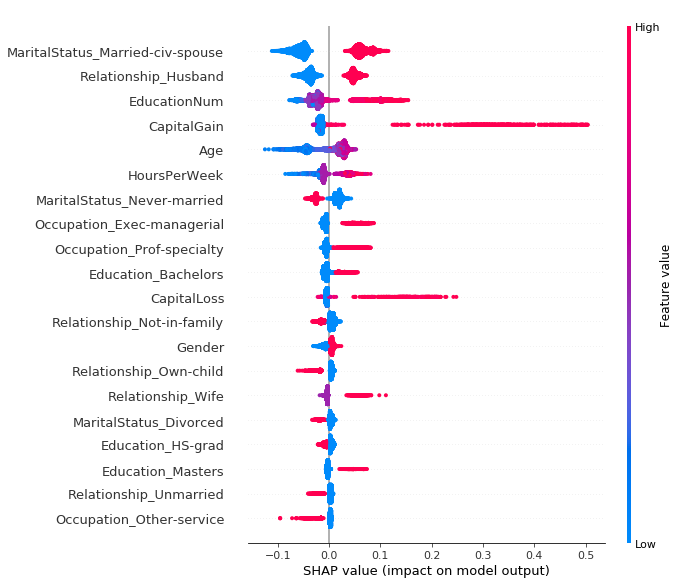

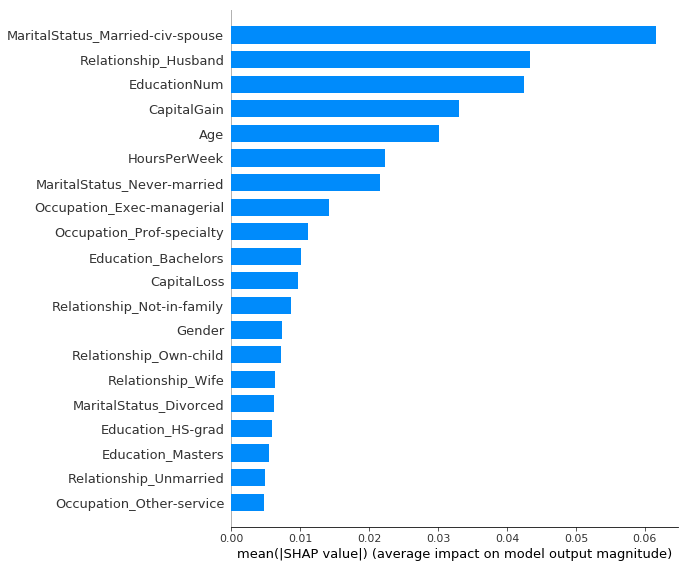

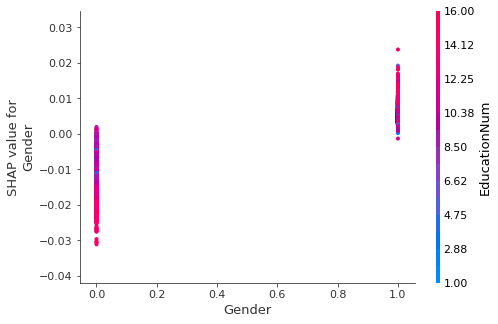

Mean SHAP value unprivileged class:  -0.010184724216422374
Mean SHAP value privileged class:  0.005927533504063564
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [25]:
print('RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_rf, 'rf_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [26]:
print('Global SHAP values by feature of Random Forest with original data: ')
df_feat

Global SHAP values by feature of Random Forest with original data: 


,feature_names,value
0,MaritalStatus_Married-civ-spouse,6.167819e-02
1,Relationship_Husband,4.337289e-02
2,EducationNum,4.247903e-02
3,CapitalGain,3.296003e-02
4,Age,3.017352e-02
...,...,...
97,NativeCountry_Guatemala,2.549435e-07
98,WorkClass_Without-pay,2.511863e-07
99,NativeCountry_Trinadad&Tobago,2.303710e-07
100,NativeCountry_Honduras,2.207894e-07


RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: 



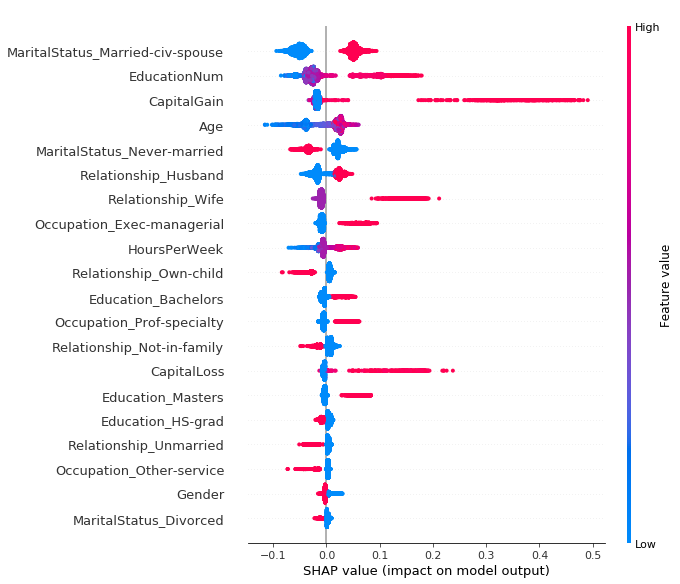

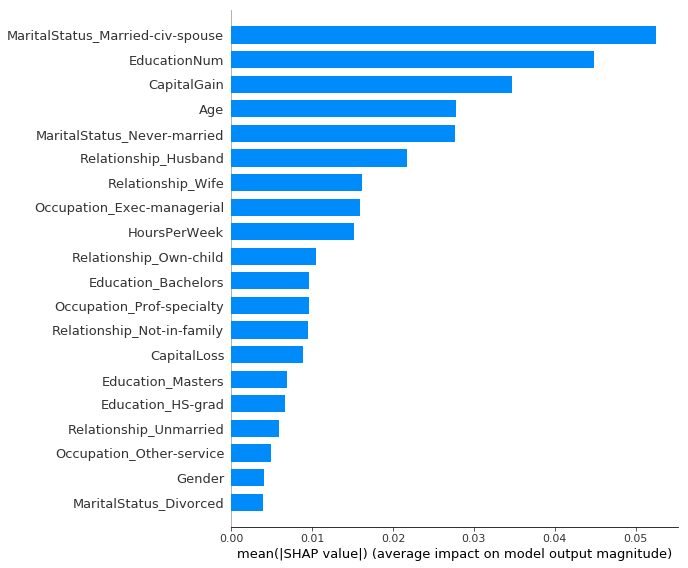

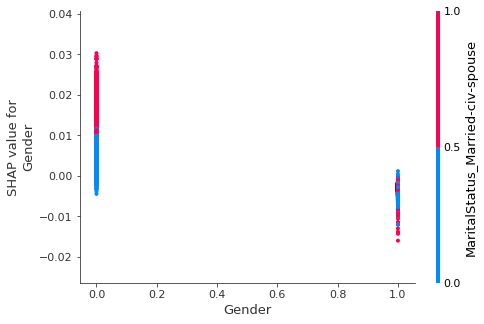

Mean SHAP value unprivileged class:  0.00605398239811557
Mean SHAP value privileged class:  -0.003023879661887306
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [27]:
print('RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_rf, 'rf_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [28]:
print('Global SHAP values by feature of Random Forest with transformed data: ')
df_feat

Global SHAP values by feature of Random Forest with transformed data: 


,feature_names,value
0,MaritalStatus_Married-civ-spouse,5.257617e-02
1,EducationNum,4.489533e-02
2,CapitalGain,3.472577e-02
3,Age,2.776003e-02
4,MaritalStatus_Never-married,2.763903e-02
...,...,...
97,NativeCountry_Honduras,5.010984e-07
98,NativeCountry_Laos,3.627720e-07
99,NativeCountry_Scotland,3.088210e-07
100,WorkClass_Never-worked,0.000000e+00


### Gradient Boosting

RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 



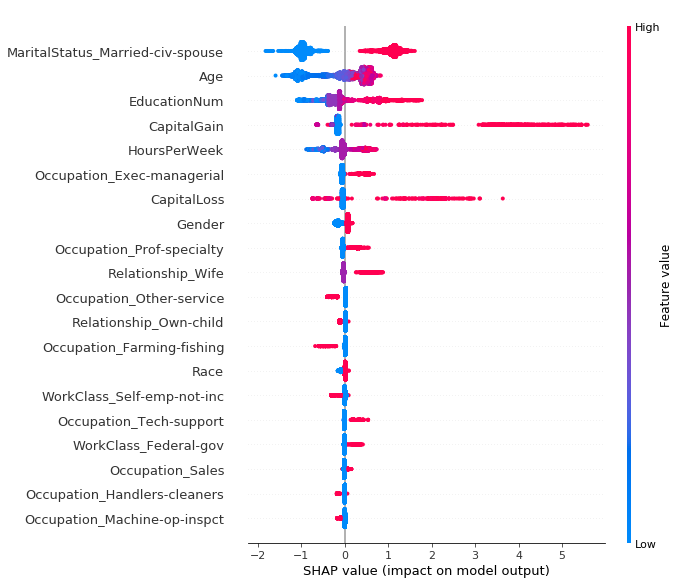

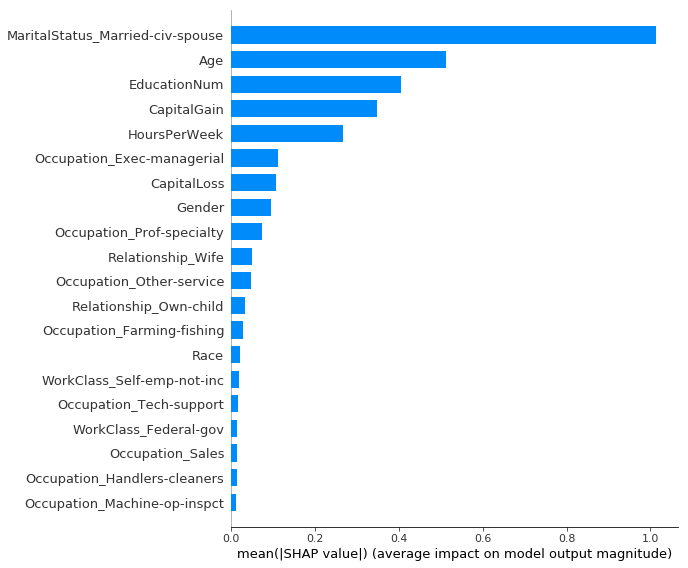

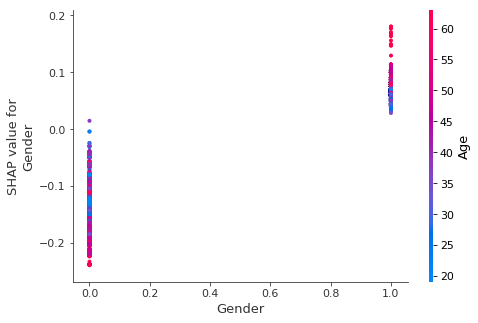

Mean SHAP value unprivileged class:  -0.14158015217830616
Mean SHAP value privileged class:  0.06985228811171397
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [29]:
print('RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_gbm, 'gbm_orig', X_train_orig, 
                                          X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [30]:
print('Global SHAP values by feature of Gradient Boosting with original data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with original data: 


,feature_names,value
0,MaritalStatus_Married-civ-spouse,1.014602
1,Age,0.511582
2,EducationNum,0.404819
3,CapitalGain,0.348427
4,HoursPerWeek,0.265507
...,...,...
97,NativeCountry_Cuba,0.000000
98,NativeCountry_Dominican-Republic,0.000000
99,NativeCountry_Ecuador,0.000000
100,NativeCountry_El-Salvador,0.000000


RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 



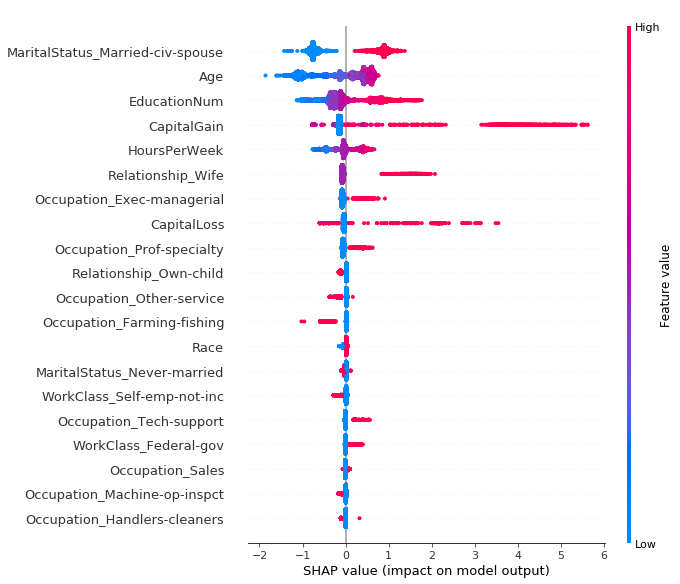

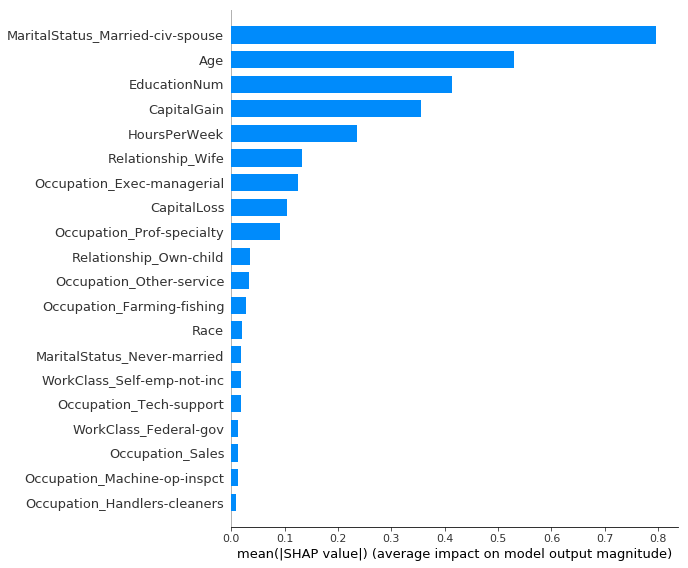

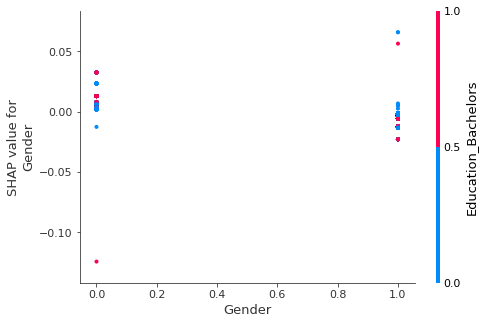

Mean SHAP value unprivileged class:  0.006759909306656069
Mean SHAP value privileged class:  -0.00409669605800606
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [31]:
print('RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_gbm, 'gbm_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [32]:
print('Global SHAP values by feature of Gradient Boosting with transformed data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with transformed data: 


,feature_names,value
0,MaritalStatus_Married-civ-spouse,0.796721
1,Age,0.530613
2,EducationNum,0.413789
3,CapitalGain,0.355002
4,HoursPerWeek,0.235753
...,...,...
97,MaritalStatus_Divorced,0.000000
98,NativeCountry_Guatemala,0.000000
99,NativeCountry_Haiti,0.000000
100,WorkClass_Without-pay,0.000000


### Logistic Regression

RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: 



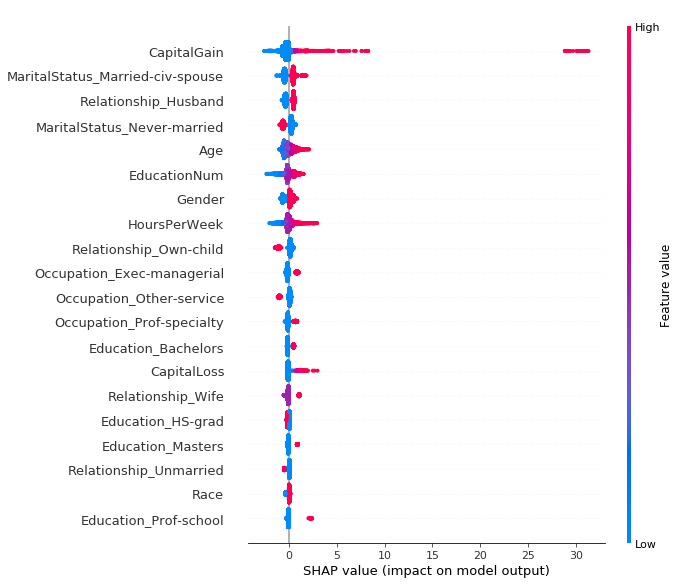

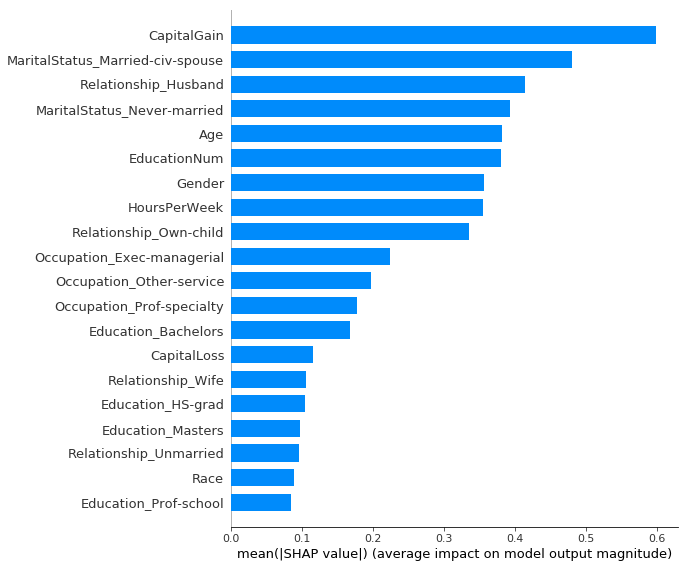

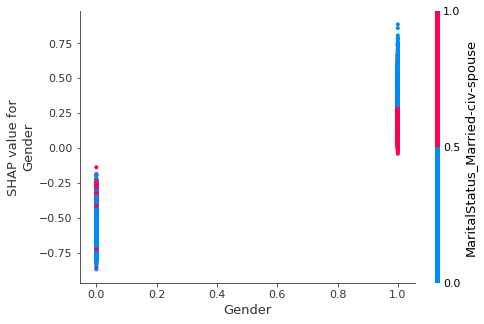

Mean SHAP value unprivileged class:  -0.5471673022648177
Mean SHAP value privileged class:  0.26217774965484575
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [33]:
print('RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_orig_lr, 'lr_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [34]:
print('Global SHAP values by feature of Logistic Regression with original data: ')
df_feat

Global SHAP values by feature of Logistic Regression with original data: 


,feature_names,value
0,CapitalGain,0.599807
1,MaritalStatus_Married-civ-spouse,0.480804
2,Relationship_Husband,0.413669
3,MaritalStatus_Never-married,0.392882
4,Age,0.382430
...,...,...
97,NativeCountry_Thailand,0.000621
98,NativeCountry_Holand-Netherlands,0.000526
99,NativeCountry_Portugal,0.000506
100,NativeCountry_France,0.000397


RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: 



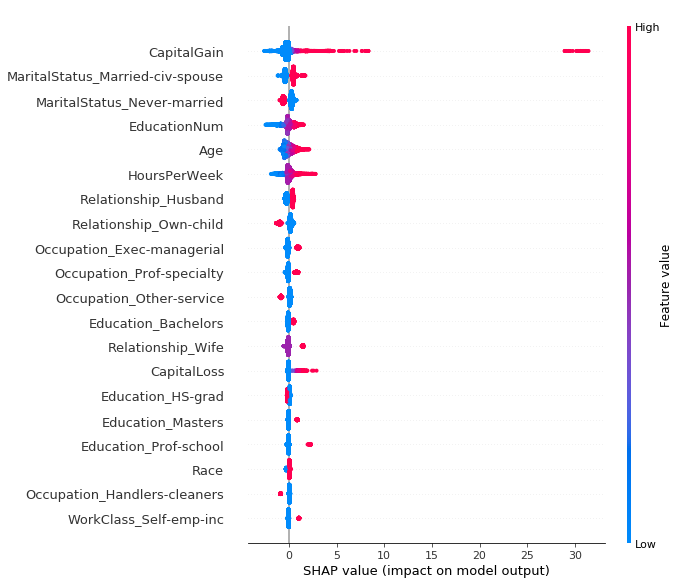

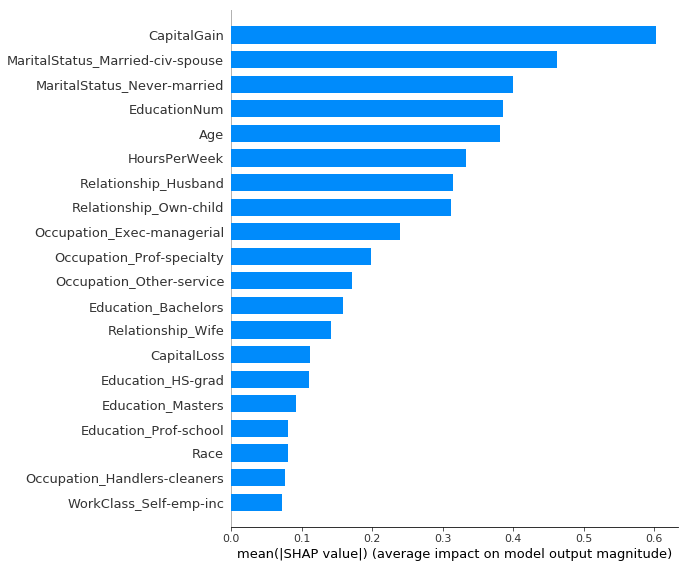

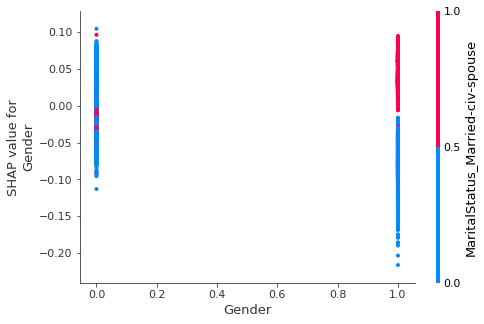

Mean SHAP value unprivileged class:  0.009582172364486845
Mean SHAP value privileged class:  -0.002002882630124064
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [35]:
print('RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_transf_lr, 'lr_transf', X_train_transf, 
                                            X_test_transf, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [36]:
print('Global SHAP values by feature of Logistic Regression with transformed data: ')
df_feat

Global SHAP values by feature of Logistic Regression with transformed data: 


,feature_names,value
0,CapitalGain,0.603375
1,MaritalStatus_Married-civ-spouse,0.461978
2,MaritalStatus_Never-married,0.400194
3,EducationNum,0.385668
4,Age,0.381276
...,...,...
97,NativeCountry_Holand-Netherlands,0.000582
98,NativeCountry_South,0.000455
99,NativeCountry_France,0.000437
100,NativeCountry_Iran,0.000352


### Final result

In [37]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 
                                           'mean_unpriv', 'mean_priv', 'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_orig,0.007337,12,-0.010185,0.005928,1,adult,0.860170,0.244023,-0.173710,0.244023,-0.106047,-0.158285,-0.016817,0.078318,0.947221
1,rf_transf,0.004047,18,0.006054,-0.003024,0,adult,0.855052,0.530744,-0.091756,0.530744,0.058766,0.124075,0.173407,0.081918,0.945747
2,gbm_orig,0.093556,7,-0.141580,0.069852,1,adult,0.869280,0.278003,-0.181024,0.278003,-0.083733,-0.109096,-0.012724,0.071511,0.930679
3,gbm_transf,0.005048,23,0.006760,-0.004097,0,adult,0.861603,0.530053,-0.100801,0.530053,0.055673,0.117890,0.187564,0.076729,0.931846
4,lr_orig,0.356385,6,-0.547167,0.262178,1,adult,0.852083,0.291660,-0.186588,0.291660,-0.090538,-0.107537,0.024598,0.079902,0.937926
5,lr_transf,0.047660,29,0.009582,-0.002003,0,adult,0.845327,0.545496,-0.098600,0.545496,0.057887,0.132108,0.175112,0.085683,0.940854


In [38]:
df_final.to_csv(path + 'result/resultado_adult.csv')